# Import

In [ ]:
import sys
sys.path.append("..")

import pandas as pd
import numpy as np
from common import *
from glob import glob
from os import rename, path
from gensim import corpora
from os.path import basename
from gensim.models import Word2Vec
from itertools import islice
from operator import itemgetter
from tqdm import tqdm
from nltk.tokenize import sent_tokenize

from joblib import Parallel, delayed
import pickle, json
from numba import jit

from matplotlib import pyplot as plt

import gensim
from gensim import corpora, models, similarities
from sklearn.metrics.pairwise import cosine_similarity

import multiprocessing
import copy, logging

cpu_count = multiprocessing.cpu_count() -1

DATA_FOLDER = '../data/'
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

Using TensorFlow backend.


# Prepare data

In [3]:
all_docs = get_all_docs(DATA_FOLDER)

In [4]:
dictionary = corpora.Dictionary.load(join(DATA_FOLDER, 'fltrd_nbelow100_nabove0.5_keepnNone.dict'))
corpus = corpora.MmCorpus(join(DATA_FOLDER, 'fltrd_nbelow100_nabove0.5_keepnNone_corpus.mm'))

2017-07-26 08:55:18,670 : INFO : loading Dictionary object from ../data/fltrd_nbelow100_nabove0.5_keepnNone.dict
2017-07-26 08:55:18,715 : INFO : loaded ../data/fltrd_nbelow100_nabove0.5_keepnNone.dict
2017-07-26 08:55:18,856 : INFO : loaded corpus index from ../data/fltrd_nbelow100_nabove0.5_keepnNone_corpus.mm.index
2017-07-26 08:55:18,857 : INFO : initializing corpus reader from ../data/fltrd_nbelow100_nabove0.5_keepnNone_corpus.mm
2017-07-26 08:55:18,858 : INFO : accepted corpus with 1194429 documents, 73924 features, 182653768 non-zero entries


In [5]:
print(corpus)

MmCorpus(1194429 documents, 73924 features, 182653768 non-zero entries)


In [6]:
fmodel = join(DATA_FOLDER, 'fltrd_nbelow100_nabove0.5_keepnNone.model')
if not path.exists(fmodel):    
    tfidf = models.TfidfModel(corpus)
    tfidf.save(fmodel)
else:
    tfidf = models.TfidfModel.load(fmodel)

2017-07-26 08:55:18,881 : INFO : loading TfidfModel object from ../data/fltrd_nbelow100_nabove0.5_keepnNone.model
2017-07-26 08:55:18,910 : INFO : loaded ../data/fltrd_nbelow100_nabove0.5_keepnNone.model


In [27]:
model = gensim.models.Word2Vec.load(join(DATA_FOLDER, 'vectors/w2v_model_500'))
wv = model.wv

2017-07-26 09:56:08,760 : INFO : loading projection weights from ../data/vectors/ruwikiruscorpora_rusvectores2.bin.gz
2017-07-26 09:56:38,354 : INFO : loaded (604043, 500) matrix from ../data/vectors/ruwikiruscorpora_rusvectores2.bin.gz


In [7]:
# wv.most_similar(positive=['стена'], topn=10)

In [13]:
with open(join(DATA_FOLDER, 'gold.json'), 'r') as f:
    gold = json.load(f)

In [9]:
# with open(join(DATA_FOLDER, 'saved/gold.txt'), 'r') as f:
#     gold_txt = f.read()
# lines = gold_txt.splitlines()
# gold = {line.split()[0]:line.split()[1:] for line in lines}


In [14]:
val_docs = glob(join(DATA_FOLDER, 'validate/*.txt'))

In [9]:
# val_docs = glob(join(DATA_FOLDER, 'saved/docs/*.txt'))

# Main functions

In [15]:
NWORDS = 15

In [16]:
@jit
def word_score(doc_tfidf, wv, dictionary):
    sorted_tfidf = sorted(doc_tfidf, key=itemgetter(1), reverse=True)
    for k,score in sorted_tfidf:
        word = dictionary.get(k)
        if word in wv:
            yield (word, score)

In [17]:
def softmax(w, t = 1.0):
    e = np.exp(np.array(w).astype(float) / t)
    dist = e / np.sum(e)
    return dist

In [18]:
def doc_vec(doc_tfidf, wv, nwords=10):
    # take top 10 most meaningfull
    scored = word_score(doc_tfidf, wv, dictionary)    
    ws = list(zip(*islice(scored, nwords)))
        
    if ws is None or len(ws) == 0:
        return np.zeros(wv.syn0.shape[1])
    
    words, scores = ws
    vecs = wv[words]    
    docvec = np.mean(vecs.T * softmax(scores), axis=1) # 

    return docvec

In [19]:
val_vecs = []
val_names = []
for fname in tqdm(val_docs):
    with open(fname, 'r') as f:
        doc_text = f.read()
    doc_bow = dictionary.doc2bow(tokenize(doc_text))
    docvec = doc_vec(tfidf[doc_bow], wv, NWORDS)
    name = path.splitext(basename(fname))[0]
    val_names.append(name)
    val_vecs.append(docvec)

# test_vecs = pd.DataFrame.from_dict(test_vecs, orient='index')

100%|██████████| 130/130 [00:00<00:00, 210.23it/s]


In [20]:
len(val_vecs)

130

In [21]:
train_vecs = []
train_names = []
for key, doc_tfidf in enumerate(tqdm(tfidf[corpus])):
    docvec = doc_vec(doc_tfidf, wv, NWORDS)
    fname = all_docs[key]
    name = path.splitext(basename(fname))[0]
    train_names.append(name)
    train_vecs.append(docvec)

100%|██████████| 1194429/1194429 [17:22<00:00, 1145.32it/s]


In [22]:
%xdel wv, model, corpus

NameError: name 'wv, model, corpus' is not defined


In [23]:
del dictionary, model, wv, corpus

In [24]:
len(train_vecs)

1194429

In [25]:
! mkdir -p {join(DATA_FOLDER, 'saved/')}

### write

In [26]:
np.save(join(DATA_FOLDER, 'saved/train.npy'), train_vecs)
np.save(join(DATA_FOLDER, 'saved/val.npy'), val_vecs)

In [27]:
with open(join(DATA_FOLDER, 'saved/names.pkl'), 'wb') as f:
    pickle.dump([train_names, val_names], f)

### read

In [7]:
train_vecs = np.load(join(DATA_FOLDER, 'saved/train.npy'))
val_vecs = np.load(join(DATA_FOLDER, 'saved/val.npy'))

In [9]:
with open(join(DATA_FOLDER, 'saved/names.pkl'), 'rb') as f:
    train_names, val_names = pickle.load(f)

# Similarity

In [28]:
sim_mat = cosine_similarity(val_vecs, train_vecs)

In [29]:
best = {}
for i, vec in enumerate(tqdm(sim_mat)):
    val_name = val_names[i]
    train_ixs = vec.argsort()[-200:][::-1]
    top_train = [train_names[i] for i in train_ixs]
    best[val_name] = top_train

100%|██████████| 130/130 [00:23<00:00,  5.81it/s]


In [30]:
with open(join(DATA_FOLDER, 'best.json'), 'w') as f:
    json.dump(best, f)

median
acc10     0.000000
acc20     0.000000
acc200    0.666667
dtype: float64
mean
acc10     0.303846
acc20     0.371026
acc200    0.579615
dtype: float64


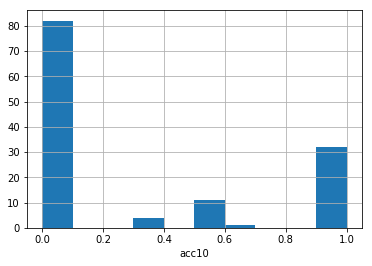

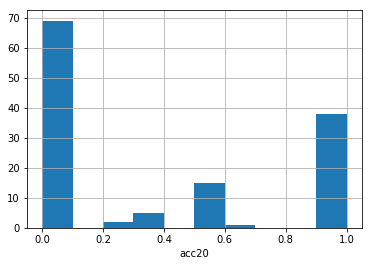

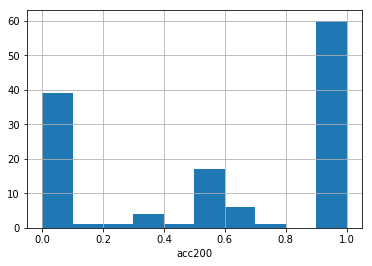

In [31]:
res = evaluate(best, gold)

In [34]:
best['235293c6-8f9a-cc52-25ee-63169c2a052f']

['20663753-bc6f-2aab-7318-67c1390426bb',
 '16536620-6eef-2119-be5d-df3d3ef7fe8d',
 '88bd5668-afc4-c40c-9a6a-ed1d96ae096f',
 'f833f071-f137-52a0-27f8-a2f1d12b23ea',
 'e07ac9c5-e04c-7466-a087-eddd918b2eae',
 'a9646d43-d330-4222-81d6-4dc918c83941',
 'e2281097-4aef-cd0e-b7d2-524454d2949f',
 '4a3457dc-2c84-092a-2d02-e8f2d16eeef6',
 'fdd49250-dffd-fcfc-ce6c-a864c1e0c573',
 'dbce075e-61c7-f693-aed0-32550c5617c8',
 'b6d6db51-b34e-4607-5d30-373744395224',
 '575627ff-a290-81c6-7694-24cf6f215293',
 'f52a3043-60cd-f012-0b05-9e67564fbca0',
 '94698b18-02d7-12ed-2936-6571e801c349',
 'a01a58cb-0153-3d96-3205-ebb2dcd14e0e',
 'afefe03f-9afc-9514-d773-558d653bc062',
 '1bbbd906-b52b-0973-04e0-36c77a43ee00',
 '7cc03787-782d-d9e4-6b38-990bea881c07',
 'da2dc768-aef1-c283-456a-7fcfad19a80b',
 '92c0a3cc-4743-447f-28fe-69a343000764',
 'ddb78a31-a35f-f376-9003-a742f1bc65d2',
 'b9949738-8ccb-da5f-63d4-91f3283e8a64',
 '096425b7-09a8-cb75-ad0f-d115a09f5c07',
 '4c94d1e3-fe6e-825a-f76e-872e87046069',
 '999bff23-ecbe-

In [32]:
gold['235293c6-8f9a-cc52-25ee-63169c2a052f']

['575627ff-a290-81c6-7694-24cf6f215293']

In [56]:
fn = [fn for fn in all_docs if '20663753-bc6f-2aab-7318-67c1390426bb' in fn][0]

In [57]:
all_docs.index(fn)

1194602

In [58]:
corpus[1194602]

[(3, 6.0),
 (4, 39.0),
 (5, 17.0),
 (6, 1.0),
 (15, 2.0),
 (18, 3.0),
 (19, 9.0),
 (26, 1.0),
 (27, 15.0),
 (35, 2.0),
 (48, 9.0),
 (54, 1.0),
 (58, 1.0),
 (60, 2.0),
 (61, 3.0),
 (63, 1.0),
 (64, 2.0),
 (67, 1.0),
 (68, 1.0),
 (69, 43.0),
 (72, 14.0),
 (79, 43.0),
 (83, 49.0),
 (95, 3.0),
 (118, 3.0),
 (121, 18.0),
 (122, 5.0),
 (133, 11.0),
 (135, 5.0),
 (137, 1.0),
 (144, 1.0),
 (148, 2.0),
 (157, 5.0),
 (160, 10.0),
 (196, 2.0),
 (197, 1.0),
 (209, 1.0),
 (213, 1.0),
 (218, 1.0),
 (227, 2.0),
 (250, 1.0),
 (260, 3.0),
 (272, 1.0),
 (276, 9.0),
 (314, 5.0),
 (315, 1.0),
 (319, 3.0),
 (326, 1.0),
 (342, 11.0),
 (350, 2.0),
 (367, 1.0),
 (376, 1.0),
 (382, 1.0),
 (397, 3.0),
 (402, 2.0),
 (404, 1.0),
 (410, 1.0),
 (428, 5.0),
 (436, 1.0),
 (456, 1.0),
 (458, 2.0),
 (469, 2.0),
 (474, 9.0),
 (476, 1.0),
 (477, 1.0),
 (495, 1.0),
 (499, 2.0),
 (500, 2.0),
 (508, 1.0),
 (524, 4.0),
 (561, 13.0),
 (593, 3.0),
 (679, 10.0),
 (684, 1.0),
 (688, 3.0),
 (710, 2.0),
 (721, 1.0),
 (728, 1.0),
 

In [69]:
sorted(tfidf[corpus[1194602]], key=itemgetter(1), reverse=True)

[(2939, 0.29383130826101217),
 (133448, 0.2665696358967095),
 (669554, 0.23861024784386),
 (669514, 0.20229593245384989),
 (669507, 0.20103984949142126),
 (669575, 0.1957831597397695),
 (669551, 0.18253372249260405),
 (478800, 0.18011610097036398),
 (140329, 0.17281097514939275),
 (164197, 0.16882743606791603),
 (669549, 0.16379654372992744),
 (79, 0.1555998357813814),
 (669523, 0.1405576061663671),
 (286528, 0.13898186261567494),
 (428114, 0.13886103086599338),
 (2940, 0.13119904229741577),
 (668892, 0.12480792649678366),
 (965, 0.1228665972233407),
 (1191, 0.12117724664793474),
 (669628, 0.1150979877319),
 (669620, 0.1087327275450038),
 (2268500, 0.10856654763638028),
 (162982, 0.10718764084624197),
 (83, 0.1061997233570332),
 (669561, 0.105709001385754),
 (2831980, 0.10555314767578823),
 (631746, 0.10371977855436332),
 (4, 0.10240839383470149),
 (77191, 0.10116129317356312),
 (6587, 0.09920293866287001),
 (73227, 0.09729791645619998),
 (669599, 0.09310510661883355),
 (669538, 0.0878

In [81]:
dictionary[133448]

'устройство'

In [63]:
test_fn = [fn for fn in val_docs if '235293c6-8f9a-cc52-25ee-63169c2a052f' in fn][0]

In [71]:
with open(test_fn, 'r') as f:
    doc_text = f.read()
doc_bow = dictionary.doc2bow(tokenize(doc_text))
sorted(tfidf[doc_bow], key=itemgetter(1), reverse=True)


[(133448, 0.5682621760252103),
 (162982, 0.39656712431357266),
 (3059, 0.29192801479528985),
 (669629, 0.23210335216318181),
 (669575, 0.17073919644384494),
 (669624, 0.16970374871335192),
 (4303, 0.15689056723710146),
 (17465, 0.1489066182825238),
 (3496779, 0.13076498554502808),
 (669563, 0.1277519367230395),
 (669631, 0.12510330922058255),
 (416065, 0.12366820466585464),
 (208467, 0.11902189028103584),
 (884879, 0.11902189028103584),
 (428114, 0.11533177759340704),
 (669555, 0.11436987560433039),
 (669523, 0.10895815219615393),
 (11561, 0.09417128426420321),
 (17737, 0.08357684545690183),
 (6150, 0.07500998448004349),
 (22348, 0.07050444061839982),
 (669546, 0.06555503500007692),
 (1566860, 0.06555503500007692),
 (2296687, 0.06374338667813824),
 (11721, 0.06352833862410387),
 (1177168, 0.06255165461029127),
 (669594, 0.06173795699432399),
 (92836, 0.061549961023167024),
 (1293114, 0.06145802658231623),
 (2831980, 0.061367414985153614),
 (669591, 0.06101746955151221),
 (140975, 0.060

In [82]:
dictionary[133448]

'устройство'

# Experiments

# Save

In [19]:
test_vecs = np.array(test_vecs)
train_vecs = np.array(train_vecs)

In [20]:
# np.save(join(DATA_FOLDER, 'bov_test_vecs.npy'), test_vecs)
# np.save(join(DATA_FOLDER, 'bov_train_vecs.npy'), train_vecs)

# Tensorboard visualization

In [88]:
import tensorflow as tf
from tensorflow.contrib.tensorboard.plugins import projector

from operator import itemgetter 
from random import sample

In [89]:
# subsample to managebale size
samp_ixs = sample(range(len(train_vecs)), 99800)
samp = list(itemgetter(*samp_ixs)(train_vecs)) + test_vecs
samp_names = list(itemgetter(*samp_ixs)(train_names)) + test_names

In [90]:
vocab_size = len(samp)
embedding_dim = model.vector_size

W = tf.Variable(tf.constant(0.0, shape=[vocab_size, embedding_dim]),
                trainable=False, name="W")
embedding_placeholder = tf.placeholder(tf.float32, [vocab_size, embedding_dim])
embedding_init = W.assign(embedding_placeholder)

In [91]:
import csv

vocab = dict(enumerate(samp_names))
vdf = pd.DataFrame.from_dict(vocab, orient='index')
vdf.to_csv('../data/processed_docs/vocab.tsv', header=False, sep='\t', index=False)


In [92]:
with tf.Session() as sess:
    final_embed_matrix = sess.run(embedding_init, feed_dict={embedding_placeholder: samp})
    
#     final_embed_matrix = sess.run(weights)

    # it has to variable. constants don't work here. you can't reuse model.embed_matrix
    embedding_var = tf.Variable(final_embed_matrix, name='documents')
    sess.run(embedding_var.initializer)

    config = projector.ProjectorConfig()
    summary_writer = tf.summary.FileWriter('../data/processed_docs')

    # add embedding to the config file
    embedding = config.embeddings.add()
    embedding.tensor_name = embedding_var.name

    # link this tensor to its metadata file, in this case the first 500 words of vocab
    embedding.metadata_path = 'vocab.tsv'

    # saves a configuration file that TensorBoard will read during startup.
    projector.visualize_embeddings(summary_writer, config)
    saver_embed = tf.train.Saver([embedding_var])
    saver_embed.save(sess, '../data/processed_docs/model3.ckpt', 1)
